# Overview

This is my second time participating in a Kaggle competition. My last [notebook](https://www.kaggle.com/code/levimjoseph/titanic) was a part of the [titanic competition](https://www.kaggle.com/competitions/titanic). I was able to achieve a good score (top ~3%) after a healthy dose of iteration and review of other successful submissions. 

For this notebook, I want to better emulate a real competition. First, I want to showcase the model evaluation required to ensure successful out-of-sample generalization. Second, I  want to work more independently from other competitor's submissions.

**Goal**: place in top the 5% of rolling leaderboard.

# Setup

In [48]:
# initial imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# set the random seed state for reproducibility
random_state = 42

# import train and test set
train_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

In [49]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [50]:
# set the dependent variable
dependent_variable = 'SalePrice'

In [51]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# EDA

In [52]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [53]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

## Data Dictionary

In [54]:
# provided data dictionary
with open('../input/house-prices-advanced-regression-techniques/data_description.txt') as f:
    print(f.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

## Categorical EDA
I will start by conducting EDA on the categorical features. I will discretize the SalePrice variable to aid in this analysis.

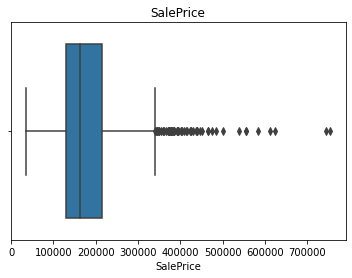

In [55]:
sns.boxplot(x=dependent_variable, data=train_df).set(title=dependent_variable)
plt.show()

There are a large number of outliers in the data. This makes sense given the housing market. 

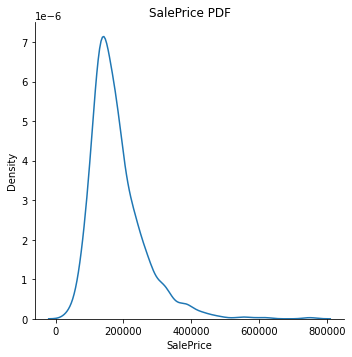

In [56]:
# use a distribution plot to showcase long-tail
sns.displot(data=train_df, x=dependent_variable, kind="kde").set(title=f'{dependent_variable} PDF')
plt.show()

I will discretize into the following buckets:
* lower: 0th to 25th percentile
* middle_lower: 25th percentile to 50th percentile
* middle_upper: 50th percentile to 75th percentile
* upper: 75th percentile to upper fence
* upper_extreme: upper fence to max value

**Note**: I do not include lower fence because it is lower than the min value (AKA no small outliers).

In [57]:
# calculate percentiles and fences
q0 = train_df[dependent_variable].quantile(0.00)
q25 = train_df[dependent_variable].quantile(0.25)
q50 = train_df[dependent_variable].quantile(0.50)
q75 = train_df[dependent_variable].quantile(0.75)
q100 = train_df[dependent_variable].quantile(1.00)

iqr = q75 - q25
lower_fence = q25 - 1.5 * iqr
upper_fence = q75 + 1.5 * iqr

In [58]:
# discretize SalePrice into four buckets:
sale_price_bins = [q0, q25, q50, q75, upper_fence, q100]
sale_price_labels = ['lower', 'middle_lower', 'middle_upper', 'upper', 'upper_extreme']

train_df['sale_price_bucket'] = pd.cut(x=train_df[dependent_variable], bins=sale_price_bins,
                    labels=sale_price_labels).astype('object')

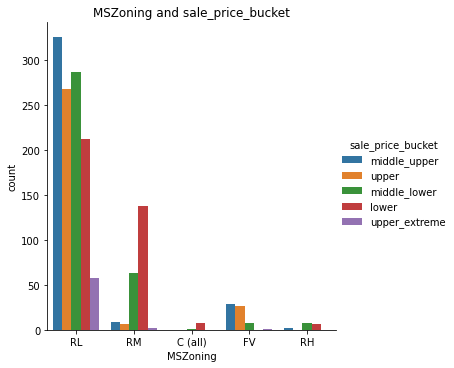

In [68]:
# 
sns.catplot(x='MSZoning', hue='sale_price_bucket', data=train_df, kind='count').set(title='MSZoning and sale_price_bucket')
plt.show()

# Modeling

## Null Imputation

In [60]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Id                 1460 non-null   int64  
 1   MSSubClass         1460 non-null   int64  
 2   MSZoning           1460 non-null   object 
 3   LotFrontage        1201 non-null   float64
 4   LotArea            1460 non-null   int64  
 5   Street             1460 non-null   object 
 6   Alley              91 non-null     object 
 7   LotShape           1460 non-null   object 
 8   LandContour        1460 non-null   object 
 9   Utilities          1460 non-null   object 
 10  LotConfig          1460 non-null   object 
 11  LandSlope          1460 non-null   object 
 12  Neighborhood       1460 non-null   object 
 13  Condition1         1460 non-null   object 
 14  Condition2         1460 non-null   object 
 15  BldgType           1460 non-null   object 
 16  HouseStyle         1460 

In [61]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

The following columns have **nulls** in the train_df:
* LotFrontage
* Alley
* MasVnrType
* MasVnrArea
* BsmtQual
* BsmtCond
* BsmtExposure
* BsmtFinType1
* BsmtFinType2
* Electrical
* FireplaceQu
* GarageType
* GarageYrBlt
* GarageFinish
* GarageQual
* GarageCond
* PoolQC
* Fence
* MiscFeature
* LotFrontage
* Alley
* MasVnrType
* MasVnrArea
* BsmtQual
* BsmtCond
* BsmtExposure
* BsmtFinType1
* BsmtFinType2
* Electrical
* FireplaceQu
* GarageType
* GarageYrBlt
* GarageFinish
* GarageQual
* GarageCond
* PoolQC
* Fence
* MiscFeature

The following columns have **nulls** in the test_df:
* MSZoning
* LotFrontage
* Alley
* Utilities
* Exterior1st
* Exterior2nd
* MasVnrType
* MasVnrArea
* BsmtQual
* BsmtCond
* BsmtExposure
* BsmtFinType1
* BsmtFinSF1
* BsmtFinType2
* BsmtFinSF2
* BsmtUnfSF
* TotalBsmtSF
* BsmtFullBath
* BsmtHalfBath
* KitchenQual
* Functional
* FireplaceQu
* GarageType
* GarageYrBlt
* GarageFinish
* GarageCars
* GarageArea
* GarageQual
* GarageCond
* PoolQC
* Fence
* MiscFeature
* SaleType

In [62]:
# categorical impute
Alley

NameError: name 'Alley' is not defined

In [63]:
# quantitative impute

# Submission

In [64]:
# construct submission
# submission_df = pd.DataFrame()
# submission_df['Id'] = m_test_df['Id'].copy()

# m_test_df.drop(columns=['Id'], inplace=True)

# submission_df['SalesPrice'] = final_model.predict(m_test_df.values)

# submission_df.to_csv('submission.csv', index=False)
# print("Your submission was successfully saved!")